# "Property Market in Perth, Western Australia"

## Data Procurement and Cleaning
Data required for this analysis:
* Prices sold between 2015 and 2020 in Perth city
* Number of bedrooms, bathrooms, carports for each property sold
* The date of sale
* Location / address
REIWA, Real East in Western Australia, is a real estate portal that keeps historical data on all properties sold, for sale and rent. Since the investor is keen on purchasing a property, the data on sold properties will be procured. The required data were scraped programmatically using BeautifulSoup. The process below entails the proposed data extraction which begins with importing all the necessary libraries needed for this analysis.

In [72]:
#import all necessary libraries required for the data analysis
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
from numpy import exp
import folium
#!pip install plotnine
from plotnine import *
#!pip install beautifulsoup4
from bs4 import BeautifulSoup
import re
from datetime import datetime
import requests
from urllib.request import urlopen
#!conda install plotly
import plotly.express as px
import plotly.graph_objects as go
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

#import all necessary libraries for Machine Learning (Supervised Learning)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import winsound

### To scrap website to acquire data using BeautifulSoup

In [2]:
#creates a dictionary with keys and values to be filled in the code below.
dictionary = {'date': [], 'address': [], 'price': [], 'dwelling': [], 'bathroom': [], 'bedroom': [], 'carport': [], 'size_m2':[]}
for page in range(1,51,1):      # Number of pages plus one 
    url = 'https://www.domain.com.au/sold-listings/perth-city-wa/?page={}'
    r = requests.get(url.format(page))
    soup = BeautifulSoup(r.content, 'lxml')
    dimension_size_list = soup.find_all("span", {"class": "css-1ie6g1l"})
    links = [link.find(class_='css-1rzse3v').text.strip() for link in dimension_size_list]
    for i in soup.find_all('p', class_ = 'css-mgq8yx'): #to extract sold date
        dictionary['price'].append(i.text.strip())
    for i in soup.find_all('h2', class_ = 'css-bqbbuf'): #to extract address
        dictionary['address'].append(i.text.strip())
    for i in soup.find_all('span', class_ = 'css-1nj9ymt'): #to extract sold property prices
        dictionary['date'].append(i.text.strip())
    for i in soup.find_all('span', class_ = 'css-693528'): #to extract info on the types of dwelling
        dictionary['dwelling'].append(i.text.strip())
    for i in links:
        if i[2:5] == 'Bed':
            dictionary['bedroom'].append(i[0]) #to extract number of bedrooms
        if i[2:5] == 'Bat':
            dictionary['bathroom'].append(i[0]) #to extract number of bathrooms
        if i[2:] == 'Parking':
            dictionary['carport'].append(i[:1]) #to extract number of carports
        if i[3:] == 'm²':
            dictionary['size_m2'].append(i[:3]) #to extract information on size in m2

winsound.Beep(frequency= 1000, duration = 1000) #alerts coder when the code finish running.

The extraction is complete. Now, it is time to set up a data frame. Below is how the data frame is set up. As seen below, there are 7 columns and 1306 observations. All the data has been classifed as object which is string value.

In [130]:
property_list = pd.DataFrame.from_dict(dictionary, orient= 'index') #creates a dataframe 
property_list = property_list.T
property_list.info() #shows the dimensions of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1000 non-null   object
 1   address   1000 non-null   object
 2   price     1000 non-null   object
 3   dwelling  1000 non-null   object
 4   bathroom  995 non-null    object
 5   bedroom   988 non-null    object
 6   carport   993 non-null    object
 7   size_m2   234 non-null    object
dtypes: object(8)
memory usage: 62.6+ KB


In [131]:
property_list.head(5)

,date,address,price,dwelling,bathroom,bedroom,carport,size_m2
0,Sold by private treaty 30 Sep 2020,"605/108 Terrace Road, EAST PERTH WA 6004","$770,000",Apartment / Unit / Flat,2,2,1,129
1,Sold by private treaty 29 Sep 2020,"312/45 Adelaide Terrace, EAST PERTH WA 6004","$220,000",Apartment / Unit / Flat,1,1,−,124
2,Sold by private treaty 29 Sep 2020,"610/2 St Georges Terrace, PERTH WA 6000","$324,000",Apartment / Unit / Flat,1,1,1,264
3,Sold by private treaty 25 Sep 2020,"4B Stuart Street, PERTH WA 6000","$680,000",House,1,3,1,124
4,Sold by private treaty 25 Sep 2020,"50/48 Havelock Street, WEST PERTH WA 6005",Price Withheld,Apartment / Unit / Flat,2,2,1,491


The column 'price' presently has many characters and digits. Since we are only interested in the digits the column goes through a tidying process by extracting only the digits and removing the commas in between them. Notice that the column 'carport' has negative value of 1. This will be further analysed.

In [132]:
property_list['price'] = property_list.price.str.replace(',','') #to remove the comma in between digits
property_list['price'] = property_list.price.str.extract('(\d+)') #to extract only the digits.

In [133]:
#to extract only dates from column date.
property_list['date'] = property_list.date.str.extract(r"(\d{2}[/. ](?:\d{2}|Jan|Feb|March|Mar|Apr|May|June|Jun|July|Jul|Aug|Sep|Sept|Oct|Nov|Dec)[/. ]\d{2}(?:\d{2})?)")

Next, the columns 'bedroom', 'bathroom' and 'carport' are examined. As seen above, there are negative values in these columns as well. A closer look of the website indicates that some properties do not have these three facilities within although they are classified as **apartments**. This is because such properties exist as one massive room apartments with no carport. It is like a room on its own and sold as an apartment unit. They are called as a [zero-bedroom apartment](https://definitions.uslegal.com/z/zero-bedroom-dwelling-hud/) or studio apartment.
For easy analysis, all negative value is converted to zero.

In [134]:
property_list.dwelling.replace('Apartment / Unit / Flat', 'Apartment', inplace= True)
property_list.dwelling.replace('New Apartments / Off the Plan', 'Off the Plan', inplace= True)

In [135]:
property_list.carport.unique() #to find the key in the column

array(['1', '−', '2', '4', '3', '9', '8', None], dtype=object)

In [136]:
property_list.bedroom.unique() #to find the key in the column

array(['2', '1', '3', '5', '4', None], dtype=object)

In [137]:
property_list[property_list['carport'] == '−'] #to list all the properties that have no carport

,date,address,price,dwelling,bathroom,bedroom,carport,size_m2
1,29 Sep 2020,"312/45 Adelaide Terrace, EAST PERTH WA 6004",220000,Apartment,1,1,−,124
19,11 Sep 2020,"113 (Lot 31)/228 James Street, NORTHBRIDGE WA...",NaN,Apartment,1,2,−,233
38,31 Aug 2020,"8/133 Lincoln Street, PERTH WA 6000",260000,Apartment,1,2,−,117
46,26 Aug 2020,"33/67 Brewer Street, PERTH WA 6000",425000,Apartment,2,2,−,241
53,23 Aug 2020,"9/1 Royal Street, EAST PERTH WA 6004",NaN,Apartment,3,4,−,165
...,...,...,...,...,...,...,...,...
961,24 Dec 2018,"908/105 Stirling Street, PERTH WA 6000",599000,Off the Plan,2,1,−,None
967,20 Dec 2018,"29 - 49 Lindsay Street, PERTH WA 6000",4867200,House,1,2,−,None
973,18 Dec 2018,"63/66 Cleaver Street, WEST PERTH WA 6005",150000,Apartment,2,3,−,None
989,11 Dec 2018,"177C Fitzgerald Street, WEST PERTH WA 6005",645000,Townhouse,2,None,−,None


In [138]:
#to convert all the '-' to '0' in the column 'carport' 
property_list['carport'] = property_list['carport'].str.replace('−','0')
property_list[property_list['carport'] == '−'] #to confirm the changes are successful

,date,address,price,dwelling,bathroom,bedroom,carport,size_m2


In [139]:
property_list['size_m2'].fillna(value=np.nan, inplace=True)

In [140]:
property_list.isna().sum() #to find any null values in the data.

date          0
address       0
price       373
dwelling      0
bathroom      5
bedroom      12
carport       7
size_m2     766
dtype: int64

In [141]:
for col in ['bedroom', 'bathroom', 'carport', 'price', 'size_m2']:
    property_list[col] = property_list[col].fillna(property_list[col].mode().iloc[0])

In [142]:
property_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1000 non-null   object
 1   address   1000 non-null   object
 2   price     1000 non-null   object
 3   dwelling  1000 non-null   object
 4   bathroom  1000 non-null   object
 5   bedroom   1000 non-null   object
 6   carport   1000 non-null   object
 7   size_m2   1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


In [143]:
property_list.isna().sum() #to confirm no NAs left in the dataset

date        0
address     0
price       0
dwelling    0
bathroom    0
bedroom     0
carport     0
size_m2     0
dtype: int64

In [144]:
#to use loop to change datatype to integer
for col in ['bedroom', 'bathroom', 'carport', 'price', 'size_m2']:
    property_list[col] = property_list[col].astype('int32')
property_list['date'] = pd.to_datetime(property_list['date'], dayfirst = True) #to set date to dd-mm-yyyy format

Next, we will be analysing the statistics of prices. On average, most properties were sold above 500 thousand dollars. I sense there are some outliers that are dragging the price up (right skewed) as the median value shows that half of the properties were sold under the 500 thousand dollars. These outliers will be examined later. Further statistical analysis will be done using visualisation.

In [145]:
property_list.info() #to check the datatype of each variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1000 non-null   datetime64[ns]
 1   address   1000 non-null   object        
 2   price     1000 non-null   int32         
 3   dwelling  1000 non-null   object        
 4   bathroom  1000 non-null   int32         
 5   bedroom   1000 non-null   int32         
 6   carport   1000 non-null   int32         
 7   size_m2   1000 non-null   int32         
dtypes: datetime64[ns](1), int32(5), object(2)
memory usage: 43.1+ KB


In [146]:
property_list.duplicated().sum() #to ascertain duplicate rows

0

In [147]:
property_list.describe() 

,price,bathroom,bedroom,carport,size_m2
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.774430e+05,1.590000,2.079000,1.253000,139.193000
std,3.662272e+05,0.615043,0.803371,0.783329,61.981622
min,1.250000e+05,1.000000,1.000000,0.000000,100.000000
25%,3.875000e+05,1.000000,2.000000,1.000000,122.000000
50%,4.000000e+05,2.000000,2.000000,1.000000,122.000000
75%,4.705000e+05,2.000000,3.000000,2.000000,122.000000
max,6.250000e+06,6.000000,5.000000,9.000000,692.000000


In [148]:
property_list[property_list.price.between(0, 100000)] #to show all properties that are sold under the minimum price.

,date,address,price,dwelling,bathroom,bedroom,carport,size_m2


Although the word 'Perth' was removed in the earlier preprocessing, some rows have address simply as 'Perth'. As seen below, the address appeared as 'Perth, Perth'. These rows are of no value to the research and so will be removed.

In [149]:
property_list.sample(10)

,date,address,price,dwelling,bathroom,bedroom,carport,size_m2
122,2020-06-22,"5/478 William Street, PERTH WA 6000",400000,Apartment,1,2,1,265
823,2019-04-05,"1301/659 Murray Street, WEST PERTH WA 6005",525000,Apartment,1,2,2,122
509,2019-10-04,"95/59-65 Malcolm Street, WEST PERTH WA 6005",400000,Apartment,1,3,1,122
59,2020-08-17,"1/44-48 Cleaver Street, WEST PERTH WA 6005",245000,Apartment,1,2,1,109
247,2020-03-03,"7/1142 Hay Street, WEST PERTH WA 6005",255000,Apartment,2,3,2,122
116,2020-06-26,"65/273 Hay Street, EAST PERTH WA 6004",290000,Apartment,1,2,1,105
944,2019-01-13,"13/500 Beaufort Street, HIGHGATE WA 6003",400000,Townhouse,2,2,1,122
836,2019-03-26,"9/4 Delhi Street, WEST PERTH WA 6005",400000,Apartment,1,2,1,122
968,2018-12-20,"2H/811 Hay Street, PERTH WA 6000",400000,Apartment,1,2,1,122
642,2019-07-19,"1803/105 Stirling Street, PERTH WA 6000",575000,Apartment,1,2,1,122


## Exploratory Data Analysis (EDA)
This is an approach to understanding the data after the cleaning process above. The data set is analysed using exploratory visuals using various visualisation tools to identify outliers, trends and patterns in the data. In the second stage of the EDA, the locations of the properties will be laid out on a map using [Folium](https://pypi.org/project/folium/) and data obtained from [Foursquare](https://foursquare.com/). A full report on this analyses is viewable [here](http://localhost:8888/notebooks/OneDrive/Projects/Data%20Science%20with%20Python/IBM%20AI%20Engineering/Coursera_Capstone/Report%20-%20Property%20Market%20in%20Perth%2C%20Western%20Australia.ipynb).

### Data Visualisation

The column dwelling reveals all the types of properties that were sold between 2015 and 2020. The types are apartment, townhouse, house, unit, duplex and off the plan. There are subtle differences amongst and between the properties. The [report](http://localhost:8888/notebooks/OneDrive/Projects/Data%20Science%20with%20Python/IBM%20AI%20Engineering/Coursera_Capstone/Report%20-%20Property%20Market%20in%20Perth%2C%20Western%20Australia.ipynb) contains explaination on the differences between the types of dwelling. Reference to 'Off The Plan'. What it means? https://www.privateproperty.com.ng/news/buying-property-off-the-plan/.

The dataset now has a total of 1021 observations and 7 variables, of which columns ‘address’ and ‘dwelling’ are categorical values while the rest (except date_sold) are discrete. The highest sale price is about 7.5 million while the lowest recorded is 155,000 dollars. The average sale price is above 500,000 dollars which indicates some outliers as the median value is about 445,000 dollars. Apart from a property (a house) with 8 bedrooms, 4 bathrooms, average property dimensions are 2 x 1 x 1 i.e. 2 bedrooms, 1 bathroom, 1 carport. The former was sold, the house demolished and now stands an apartment building.

In [150]:
property_list.describe(percentiles = [0.1,0.25,0.5,0.75,0.9])

,price,bathroom,bedroom,carport,size_m2
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.774430e+05,1.590000,2.079000,1.253000,139.193000
std,3.662272e+05,0.615043,0.803371,0.783329,61.981622
min,1.250000e+05,1.000000,1.000000,0.000000,100.000000
10%,2.800000e+05,1.000000,1.000000,1.000000,122.000000
25%,3.875000e+05,1.000000,2.000000,1.000000,122.000000
50%,4.000000e+05,2.000000,2.000000,1.000000,122.000000
75%,4.705000e+05,2.000000,3.000000,2.000000,122.000000
90%,7.254500e+05,2.000000,3.000000,2.000000,163.100000
max,6.250000e+06,6.000000,5.000000,9.000000,692.000000


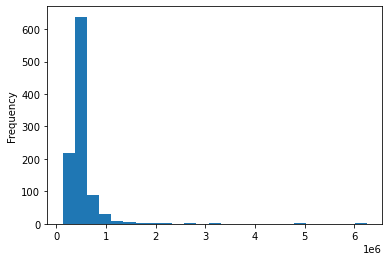

In [151]:
property_list['price'].plot.hist(bins = 25);

A significant portion of the sale involved apartments, about 75% of the properties sold. Only a meagre 17% involved houses and  4% for each, units townhouses.

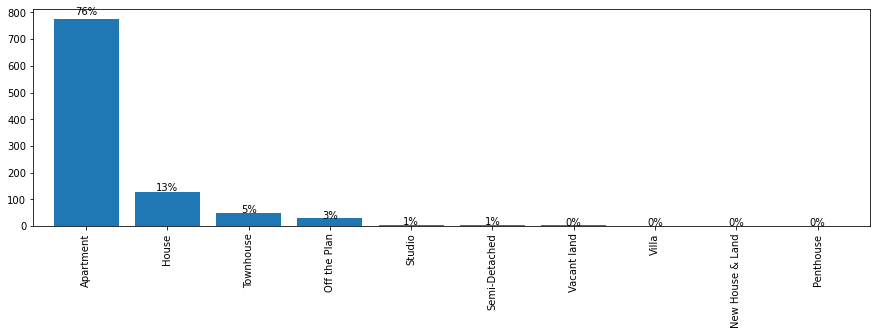

In [152]:
#to find out which type of dwelling was sold the most
ax = pd.value_counts(property_list.dwelling).plot(kind='bar',figsize=(15,4),width = 0.8)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height/1021), (x + width/2, y + height*1.02), ha='center')

<AxesSubplot:ylabel='Density'>

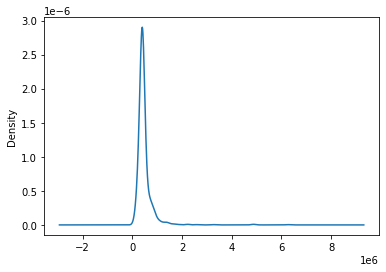

In [153]:
property_list['price'].plot.density()

In [154]:
#using plotly.express
px.box(property_list, x='dwelling', y = 'price',
      title='The Sale of Properties in Australian Dollar (AUD)', 
             labels = {'dwelling':'Types of Dwelling', 'price': 'Price in AUD'})#to find out how the price fares against the types of dwelling.

In [155]:
px.box(property_list, x='bedroom', y = 'price',
      title='The Price vs Number of Bedrooms in AUD', 
             labels = {'bedroom':'Number of Bedrooms in a Property', 'price': 'Price in AUD'})#to find out how the price fares against number of bedrooms.

In [156]:
px.box(property_list, x='bathroom', y = 'price',
      title='The Price vs Number of Bathrooms in AUD', 
             labels = {'bathroom':'Number of Bathrooms in a Property', 'price': 'Price in AUD'})#to find out how the price fares against number of bathrooms.

There are outliers and they are affecting the distribution of the prices. 

In [157]:
property_list['day'] = property_list['date'].dt.day_name()
property_list['day_of_week'] = property_list['date'].dt.dayofweek
property_list['weekend'] = property_list['day_of_week'].apply(lambda x: 1 if (x > 4) else 0)

In [29]:
property_list.head()

,date,address,price,dwelling,bathroom,bedroom,carport,size_m2,day,day_of_week,weekend
0,2020-09-30,"605/108 Terrace Road, EAST PERTH WA 6004",770000,Apartment,2,2,1,129,Wednesday,2,0
1,2020-09-29,"312/45 Adelaide Terrace, EAST PERTH WA 6004",220000,Apartment,1,1,0,124,Tuesday,1,0
2,2020-09-29,"610/2 St Georges Terrace, PERTH WA 6000",324000,Apartment,1,1,1,264,Tuesday,1,0
3,2020-09-25,"4B Stuart Street, PERTH WA 6000",680000,House,1,3,1,124,Friday,4,0
5,2020-09-24,"73/189 Adelaide Terrace, EAST PERTH WA 6004",570000,Apartment,2,2,1,519,Thursday,3,0


In [158]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=cats, ordered=True)
property_list['day'] = property_list['day'].astype(cat_type) #to order the categorical values, 'day'

In [159]:
#to see on which day most properties were sold and which type.
px.histogram(property_list, x=property_list['day'].sort_values(), y='price', color = 'dwelling', nbins = 17, 
             title='The Top Days Most Sale of Properties Occured', 
             labels = {'x':"", 'dwelling': 'Types of Dwelling', 'price': 'Price in AUD'})

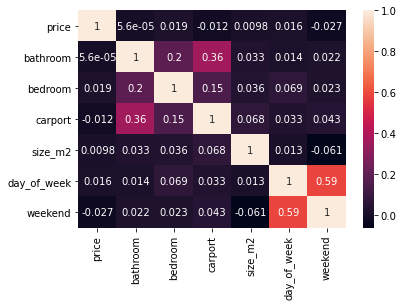

In [160]:
sb.heatmap(property_list.corr('pearson'), annot=True)
plt.show()

#### Set up Foursquare Developer credentials

In [33]:
foursquare_credentials = pd.read_csv("Foursquare_credentials.csv")
CLIENT_ID = foursquare_credentials.Client_ID # your Foursquare ID
CLIENT_SECRET = foursquare_credentials.Client_secret # your Foursquare Secret
VERSION = '20201018'
LIMIT = 30

To get the coordinates of Perth CBD

In [34]:
address = 'St. Georges Terrace, Perth, Western Australia 6000'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The latitude and longitude of Perth CBD: ',latitude, longitude)

The latitude and longitude of Perth CBD:  -31.9549901 115.8575217


### To search for restaurant within Perth CBD

In [35]:
search_query = 'restaurant'
radius = 1000
print(search_query + ' .... OK!')

restaurant .... OK!


In [36]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID[0], CLIENT_SECRET[0], latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=S2RFPKBHSMYQBRNTNCIKSJJRRATXJCBRSNBVRP5QM2CNAQRR&client_secret=BJOGJAYH0L4E3XKO5QCI4ZYW4YJL2YV0CZKJ5W2UBZVKXX43&ll=-31.9549901,115.8575217&v=20201018&query=restaurant&radius=1000&limit=30'

In [37]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f76eb1e35003924238a3839'},
 'response': {'venues': [{'id': '4b74d676f964a520adf42de3',
    'name': 'Restaurant Jun 純',
    'location': {'address': '568 Hay St',
     'lat': -31.954960004737625,
     'lng': 115.86138457664951,
     'labeledLatLngs': [{'label': 'display',
       'lat': -31.954960004737625,
       'lng': 115.86138457664951}],
     'distance': 364,
     'postalCode': '6000',
     'cc': 'AU',
     'city': 'Perth',
     'state': 'WA',
     'country': 'Australia',
     'formattedAddress': ['568 Hay St', 'Perth WA 6000', 'Australia']},
    'categories': [{'id': '4bf58dd8d48988d111941735',
      'name': 'Japanese Restaurant',
      'pluralName': 'Japanese Restaurants',
      'shortName': 'Japanese',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1601628958',
    'hasPerk': False},
   {'id': '55ed79a3498e6eaf2fbcebde',
    'name': 'Cant

In [38]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe_rest = pd.json_normalize(venues)
dataframe_rest.head(3)

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,4b74d676f964a520adf42de3,Restaurant Jun 純,"[{'id': '4bf58dd8d48988d111941735', 'name': 'J...",v-1601628958,False,568 Hay St,-31.954960,115.861385,"[{'label': 'display', 'lat': -31.9549600047376...",364,6000,AU,Perth,WA,Australia,"[568 Hay St, Perth WA 6000, Australia]",NaN,NaN
1,55ed79a3498e6eaf2fbcebde,Canton Bay Chinese Restaurant Northbridge 喜粵海鮮酒家,"[{'id': '52af3a7c3cf9994f4e043bed', 'name': 'C...",v-1601628958,False,20 Roe St,-31.949653,115.858080,"[{'label': 'display', 'lat': -31.9496528483201...",596,NaN,AU,Northbridge,WA,Australia,"[20 Roe St, Northbridge WA, Australia]",NaN,NaN
2,4b61256cf964a5201b0b2ae3,Dragon Palace & Karaoke Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1601628958,False,66 Francis St,-31.947489,115.858610,"[{'label': 'display', 'lat': -31.9474889923021...",841,6003,AU,Northbridge,WA,Australia,"[66 Francis St (nr Lake St), Northbridge WA 60...",nr Lake St,NaN


### To search for cafes within CBD

In [39]:
search_query = 'cafes'
radius = 1000
print(search_query + ' .... OK!')

cafes .... OK!


In [40]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID[0], CLIENT_SECRET[0], latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=S2RFPKBHSMYQBRNTNCIKSJJRRATXJCBRSNBVRP5QM2CNAQRR&client_secret=BJOGJAYH0L4E3XKO5QCI4ZYW4YJL2YV0CZKJ5W2UBZVKXX43&ll=-31.9549901,115.8575217&v=20201018&query=cafes&radius=1000&limit=30'

In [41]:
results = requests.get(url).json()

In [42]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe_cafe = pd.json_normalize(venues)
dataframe_cafe.head(3)

,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.address,location.crossStreet
0,578ec414498ebef9383e2e21,Cafe Studio,"[{'id': '4bf58dd8d48988d1a1941735', 'name': 'C...",v-1601628959,False,-31.953068,115.861230,"[{'label': 'display', 'lat': -31.953068, 'lng'...",410,6000,AU,Perth,WA,Australia,"[Perth WA 6000, Australia]",NaN,NaN
1,5855eb88fad9dc0635d26be2,Cafe Studio Perth,"[{'id': '52e81612bcbc57f1066b79f1', 'name': 'B...",v-1601628959,False,-31.952731,115.861296,"[{'label': 'display', 'lat': -31.9527311933084...",436,6000,AU,Perth,WA,Australia,"[138 Barrack Street (Wellington Street), Perth...",138 Barrack Street,Wellington Street
2,4b610e01f964a52005082ae3,Café St George,[],v-1601628959,False,-31.953175,115.849256,"[{'label': 'display', 'lat': -31.9531754780512...",806,6000,AU,Perth,WA,Australia,"[251 St Georges Tce, Perth WA 6000, Australia]",251 St Georges Tce,NaN


### To search for bakeries within CBD

In [43]:
search_query = 'bakery'
radius = 1000
print(search_query + ' .... OK!')

bakery .... OK!


In [44]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID[0], CLIENT_SECRET[0], latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=S2RFPKBHSMYQBRNTNCIKSJJRRATXJCBRSNBVRP5QM2CNAQRR&client_secret=BJOGJAYH0L4E3XKO5QCI4ZYW4YJL2YV0CZKJ5W2UBZVKXX43&ll=-31.9549901,115.8575217&v=20201018&query=bakery&radius=1000&limit=30'

In [45]:
results = requests.get(url).json()

In [46]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe_bakery = pd.json_normalize(venues)
dataframe_bakery.head(3)

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,location.crossStreet
0,4b8de8ccf964a520041333e3,Hay Street Bakery,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",v-1601628959,False,Hay St,-31.953164,115.855744,"[{'label': 'display', 'lat': -31.9531635969671...",263,6000,AU,Perth,WA,Australia,"[Hay St, Perth WA 6000, Australia]",NaN,NaN
1,595ef60f35d3fc3e62118289,Mary Street Bakery (St Georges),"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",v-1601628959,False,NaN,-31.955444,115.858501,"[{'label': 'display', 'lat': -31.9554443144621...",105,6000,AU,Perth,WA,Australia,"[Perth WA 6000, Australia]",NaN,NaN
2,581bd500b148840eb14c993f,Mary St Bakery,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1601628959,False,NaN,-31.951946,115.851071,"[{'label': 'display', 'lat': -31.951946, 'lng'...",697,NaN,AU,NaN,NaN,Australia,[Australia],Perth CBD,NaN


> To filter columns for restaurant's name and coordinates

In [47]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe_rest.columns if col.startswith('location.')] + ['id']
dataframe_filtered_rest = dataframe_rest.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_rest['categories'] = dataframe_filtered_rest.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_rest.columns = [column.split('.')[-1] for column in dataframe_filtered_rest.columns]

dataframe_filtered_rest.head(3)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Restaurant Jun 純,Japanese Restaurant,568 Hay St,-31.954960,115.861385,"[{'label': 'display', 'lat': -31.9549600047376...",364,6000,AU,Perth,WA,Australia,"[568 Hay St, Perth WA 6000, Australia]",NaN,NaN,4b74d676f964a520adf42de3
1,Canton Bay Chinese Restaurant Northbridge 喜粵海鮮酒家,Cantonese Restaurant,20 Roe St,-31.949653,115.858080,"[{'label': 'display', 'lat': -31.9496528483201...",596,NaN,AU,Northbridge,WA,Australia,"[20 Roe St, Northbridge WA, Australia]",NaN,NaN,55ed79a3498e6eaf2fbcebde
2,Dragon Palace & Karaoke Restaurant,Chinese Restaurant,66 Francis St,-31.947489,115.858610,"[{'label': 'display', 'lat': -31.9474889923021...",841,6003,AU,Northbridge,WA,Australia,"[66 Francis St (nr Lake St), Northbridge WA 60...",nr Lake St,NaN,4b61256cf964a5201b0b2ae3


> To filter columns for name and category of cafes

In [48]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe_cafe.columns if col.startswith('location.')] + ['id']
dataframe_filtered_cafe = dataframe_cafe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_cafe['categories'] = dataframe_filtered_cafe.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_cafe.columns = [column.split('.')[-1] for column in dataframe_filtered_cafe.columns]

> To filter columns for name and category of bakeries

In [49]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe_bakery.columns if col.startswith('location.')] + ['id']
dataframe_filtered_bakery = dataframe_bakery.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_bakery['categories'] = dataframe_filtered_bakery.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_bakery.columns = [column.split('.')[-1] for column in dataframe_filtered_bakery.columns]

> To extract coordinates of properties to be used in the map.

In [173]:
dict_coord = {'lat': [], 'lng': []}
for loc in property_list['address']:
    geolocator = Nominatim(user_agent = 'foursquare_agent')
    location = geolocator.geocode(loc)
    if location == None:
        np.nan
    else:
        dict_coord['lat'].append(location.latitude)
        dict_coord['lng'].append(location.longitude)
        
coordinates = pd.DataFrame.from_dict(dict_coord)
winsound.Beep(frequency= 1000, duration = 1000) #alerts coder when code finishes running.

> To create a map using Folium and markers to differentiate cafes, restaurants and bakeries in the CBD. The red marker will show where the properties are and their respective prices.

In [51]:
address = 'St. Georges Terrace, Perth, Western Australia 6000'

geolocator = Nominatim(user_agent="capstone")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
price = property_list.price.apply(str) #to convert int to str for mapping purposes only.

perth_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Perth CBD

# add a black circle marker to represent the region
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='black',
    popup='Perth CBD',
    fill = True,
    fill_color = 'black',
    fill_opacity = 0.6
).add_to(perth_map)

# add the restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered_rest.lat, dataframe_filtered_rest.lng, dataframe_filtered_rest.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
).add_to(perth_map)

# add the cafes as yellow circle markers
for lat, lng, label in zip(dataframe_filtered_cafe.lat, dataframe_filtered_cafe.lng, dataframe_filtered_cafe.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.2
).add_to(perth_map)

# add the bakeries as pink circle markers
for lat, lng, label in zip(dataframe_filtered_bakery.lat, dataframe_filtered_bakery.lng, dataframe_filtered_bakery.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
).add_to(perth_map)

# add the location of properties as red circle markers
for lat, lng, label in zip(coordinates.lat, coordinates.lng, price): #the price will show when clicked on the red circle.
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
).add_to(perth_map)
    
# display map
perth_map

To create a dataframe that holds all 3-bedroom apartments selling at the moment in Perth CDB.

In [52]:
dict_sale = {'address': [], 'price': [], 'dwelling': [], 'bathroom': [], 'bedroom': [], 'carport': [], 'size_m2':[]}
for page in range(1,51,1):      # Number of pages plus one 
    url = 'https://www.domain.com.au/sale/perth-city-wa/?page={}'
    r = requests.get(url.format(page))
    soup = BeautifulSoup(r.content, 'lxml')
    dimension_size_list = soup.find_all("span", {"class": "css-1ie6g1l"})
    links = [link.find(class_='css-1rzse3v').text.strip() for link in dimension_size_list]
    for i in soup.find_all('p', class_ = 'css-mgq8yx'): #to extract sold date
        dict_sale['price'].append(i.text.strip())
    for i in soup.find_all('h2', class_ = 'css-bqbbuf'): #to extract address
        dict_sale['address'].append(i.text.strip())
    for i in soup.find_all('span', class_ = 'css-693528'): #to extract info on the types of dwelling
        dict_sale['dwelling'].append(i.text.strip())
    for i in links:
        if i[2:5] == 'Bed':
            dict_sale['bedroom'].append(i[0])
        if i[2:5] == 'Bat':
            dict_sale['bathroom'].append(i[0])
        if i[2:] == 'Parking':
            dict_sale['carport'].append(i[:1])
        if i[3:] == 'm²':
            dict_sale['size_m2'].append(i[:3])

winsound.Beep(frequency= 1000, duration = 1000) #alerts coder when the code finish running.')

In [161]:
property_sale = pd.DataFrame.from_dict(dict_sale, orient= 'index')
property_sale = property_sale.T
property_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   565 non-null    object
 1   price     565 non-null    object
 2   dwelling  565 non-null    object
 3   bathroom  545 non-null    object
 4   bedroom   542 non-null    object
 5   carport   553 non-null    object
 6   size_m2   150 non-null    object
dtypes: object(7)
memory usage: 31.0+ KB


In [164]:
for col in ['bedroom', 'bathroom', 'carport', 'price', 'size_m2']:
    property_sale[col] = property_sale[col].fillna(property_sale[col].mode().iloc[0])

In [165]:
property_sale.isna().sum()

address     0
price       0
dwelling    0
bathroom    0
bedroom     0
carport     0
size_m2     0
dtype: int64

In [166]:
property_sale['carport'] = property_sale['carport'].replace('−', '0')

In [167]:
for col in ['bedroom', 'bathroom', 'carport', 'size_m2']:
    property_sale[col] = property_sale[col].astype('int32')

In [168]:
property_sale['price'] = property_sale.price.str.replace(',','') #to remove the comma in between digits
property_sale['price'] = property_sale.price.str.extract('(\d+)') #to extract only the digits.

In [169]:
property_sale.dwelling.replace('Apartment / Unit / Flat', 'Apartment', inplace= True)
property_sale.dwelling.replace('New Apartments / Off the Plan', 'Off the Plan', inplace= True)
property_sale.dropna(inplace = True)

In [171]:
property_sale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 0 to 564
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   410 non-null    object
 1   price     410 non-null    object
 2   dwelling  410 non-null    object
 3   bathroom  410 non-null    int32 
 4   bedroom   410 non-null    int32 
 5   carport   410 non-null    int32 
 6   size_m2   410 non-null    int32 
dtypes: int32(4), object(3)
memory usage: 19.2+ KB


To get the coordinates of all the apartments.

In [172]:
sale_coord = {'lat': [], 'lng': []}
for loc in property_sale['address']:
    geolocator = Nominatim(user_agent = 'foursquare_agent')
    location = geolocator.geocode(loc)
    if location == None:
        np.nan
    else:
        sale_coord['lat'].append(location.latitude)
        sale_coord['lng'].append(location.longitude)
        
sale_coordinates = pd.DataFrame.from_dict(sale_coord)

winsound.Beep(1000, 1000) #alerts coder when code finishes running.

In [175]:
property_sale.to_csv('sale_property.csv', index = False)
sale_coordinates.to_csv('sale_coordinates.csv', index = False)
property_list.to_csv('property_list.csv', index = False)
coordinates.to_csv('coordinates.csv', index=False)

__To predict the selling prices of apartments__

In [192]:
#One-hot coding to numerate the categorical values in column 'dwelling'

Features = property_list[['bedroom', 'bathroom', 'carport', 'size_m2']]
Features = pd.concat([Features, pd.get_dummies(property_list['dwelling'])], axis = 1)
Features.head(3)

,bedroom,bathroom,carport,size_m2,Apartment,House,New House & Land,Off the Plan,Penthouse,Semi-Detached,Studio,Townhouse,Vacant land,Villa
0,2,2,1,129,1,0,0,0,0,0,0,0,0,0
1,1,1,0,124,1,0,0,0,0,0,0,0,0,0
2,1,1,1,264,1,0,0,0,0,0,0,0,0,0


In [193]:
X = Features
y = property_list['price']

print('The dimension of Features is {} and Target {}'.format(X.shape, y.shape))

The dimension of Features is (1000, 14) and Target (1000,)


#### NORMALISE DATA, CLASSIFICATION, AND MODEL EVALUATION USING LIINEAR REGRESSION

In [194]:
#split Features(X) into training and testing data at ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print('The dimension of X_train is {} and y_train {}'.format(X_train.shape, y_train.shape))
print('The dimension of X_test is {} and y_test {}'.format(X_test.shape, y_test.shape))

The dimension of X_train is (700, 14) and y_train (700,)
The dimension of X_test is (300, 14) and y_test (300,)


In [195]:
#Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
yhat = regr.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(y_test, yhat))

Coefficient of determination: 0.11


In [196]:
Features_sale = property_sale[['bedroom', 'bathroom', 'carport', 'size_m2']]
Features_sale = pd.concat([Features_sale, pd.get_dummies(property_sale['dwelling'])], axis = 1)
Features_sale.drop('Unknown', axis = 1, inplace = True)
Features_sale.head(3)

,bedroom,bathroom,carport,size_m2,Apartment,House,New Home Designs,New House & Land,Off the Plan,Penthouse,Studio,Townhouse,Vacant land,Villa
0,2,2,1,509,1,0,0,0,0,0,0,0,0,0
1,3,2,1,890,0,1,0,0,0,0,0,0,0,0
2,4,4,2,340,1,0,0,0,0,0,0,0,0,0


In [197]:
X_sale = Features_sale
y_sale = property_sale['price']
print('The dimension of X_sale is {} and y_sale {}'.format(X_sale.shape, y_sale.shape))

The dimension of X_sale is (410, 14) and y_sale (410,)


In [198]:
regr.fit(X_train, y_train)
yhat_sale = regr.predict(X_sale)

In [199]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_sale, yhat_sale))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(y_sale, yhat_sale))

Mean squared error: 276197002225.45
Coefficient of determination: 0.00


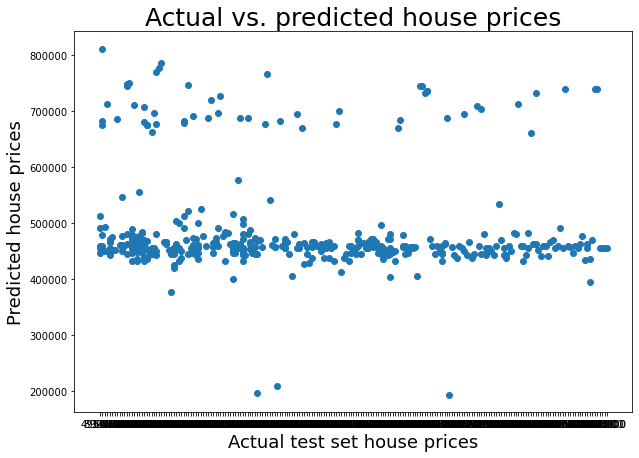

In [200]:
plt.figure(figsize=(10,7))
plt.title("Actual vs. predicted house prices",fontsize=25)
plt.xlabel("Actual test set house prices",fontsize=18)
plt.ylabel("Predicted house prices", fontsize=18)
plt.scatter(x=y_sale,y=yhat_sale)